In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import GPy


sns.set_style('darkgrid')

In [2]:
def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

In [11]:
def autoco(ws1, ws2, figname):

    plt.figure(figsize=(20,10))
    
    x=np.asarray(ws1)
    y=autocorr2(x, range(len(x)))
    plt.plot(range(y.size), abs(y), label='Referencia', c='Darkblue')
    
    x2=np.asarray(ws2)
    y2=autocorr2(x2, range(len(x2)))
    plt.plot(range(y2.size), abs(y2), label='Sintética', c='r')
    
    
    autoco.error=y-y2
    
    
    plt.xlabel('Orden de muestras', size=25)
    plt.ylabel('Autocorrelación', size=25)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    xmin, xmax = plt.xlim()
    #plt.xlim(0, xmax)
    plt.legend(fontsize=25)
    
    plt.savefig('../output_figures/GP_process/'+figname+'.png', format='png', dpi=360, bbox_inches="tight")
    
    return(plt.show())

In [4]:
def two_time_serie(ws1, ws2, figname):
    plt.figure(figsize=(30,10))
    
    ws1.plot(label='Referencia', color='darkblue')
    plt.xticks(fontsize=25)
    
    ws2.plot(label='Sintética', color='red', style='--', markersize=20)
    
    
    plt.xlabel('Tiempo', size=25)
    plt.ylabel('U [$m/s$]', size=25)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    
    plt.legend(fontsize=25)
    plt.savefig('../output_figures/GP_process/'+figname+'.png', format='png', dpi=360, bbox_inches="tight")
    plt.show()

In [5]:
#Import data
df_day=pd.read_csv('../output_data/ventosa_2018_01_20.csv', index_col='Tiempo', parse_dates=True)
df_day_10m=df_day.resample('10T').mean()
df_error1=pd.read_csv('../output_data/fft_test/error_24h.csv', index_col='Tiempo', parse_dates=True)

GP_regression.,value,constraints,priors
periodic_Matern32.variance,0.5289220099631743,+ve,
periodic_Matern32.lengthscale,0.1,+ve,
periodic_Matern32.period,6.283185307179586,+ve,
Gaussian_noise.variance,0.001,+ve,


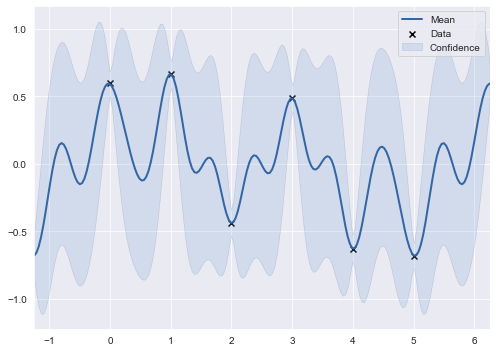

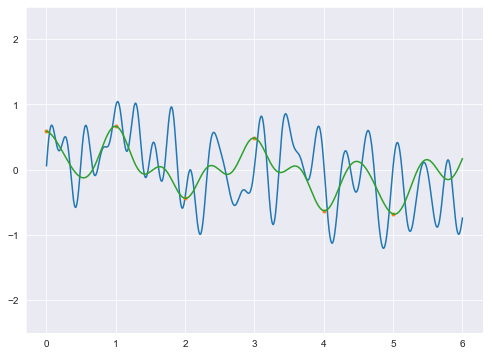

In [6]:
#Visualización del ajuste del proceso gaussiano

i=0
serie=df_error1.Fou[600*i:600*i+3600]-np.mean(df_error1.Fou[600*i:600*i+3600])
muestras=df_day_10m.ws[i:i+6]-np.mean(df_day_10m.ws[i:i+6]) #media movil

sp=6

y=np.array(muestras)
x=np.arange(0,y.size)

gpy_y=y.reshape(y.size, 1)
gpy_x=x.reshape(x.size, 1)

kernel =GPy.kern.PeriodicMatern32(1, variance=np.var(df_error1.Fou), lengthscale=0.1, period=2*np.pi)
m = GPy.models.GPRegression(gpy_x, gpy_y, kernel)
m.Gaussian_noise.variance=0.001

m.plot(figsize=(7,5))
#plt.savefig('GPY1_1.png', format='png', dpi=360, bbox_inches="tight")

plt.figure(figsize=(8.2,6))
y2, x2 = serie , np.linspace(0, y.size, serie.size)
plt.plot(x2, y2, '-')

plt.plot(x, y, '.')
plt.ylim(-2.5, 2.5,1)

Xp=np.linspace(0,sp,sp*600)[:,None]
mu, C = m.predict(Xp, full_cov=True, Y_metadata=True)
 
muT=mu+np.mean(df_day_10m.ws[i:i+6]) 

plt.plot(Xp, mu)
#plt.savefig('GPY1_2.png', format='png', dpi=360, bbox_inches="tight")
m

In [7]:
def GProcess(i):
    
    serie=df_error1.Fou[600*i:600*i+3600]-np.mean(df_error1.Fou[600*i:600*i+3600])
    muestras=df_day_10m.ws[i:i+6]-np.mean(df_day_10m.ws[i:i+6])
    
    sp=6
    
    y=np.array(muestras)
    x=np.arange(0,y.size)
    
    gpy_y=y.reshape(y.size, 1)
    gpy_x=x.reshape(x.size, 1)
    
    kernel =GPy.kern.PeriodicMatern32(1, variance=np.var(df_error1.Fou), lengthscale=0.1, period=2*np.pi)
    
    m = GPy.models.GPRegression(gpy_x, gpy_y, kernel)
    m.Gaussian_noise.variance=0.001
    
    Xp=np.linspace(0,sp,sp*600)[:,None]
    mu, C = m.predict(Xp, full_cov=True, Y_metadata=True)
     
    muT=mu+np.mean(df_day_10m.ws[i:i+6])
    
    return (muT)

In [8]:
cont=[]
pred=[GProcess(i) for i in range(139)]

cont.append(pred[0])
[cont.append(pred[i][0:600]) for i in range(1,138)]

senal1= np.concatenate(cont).flatten()
noise=np.random.normal(df_error1.ws.mean(), df_error1.ws.std(), size=senal1.size)

senal_sintetica=senal1+noise

df_signs= pd.DataFrame(df_day.ws[0:len(senal_sintetica)])
df_signs['Matern32_1']=senal_sintetica

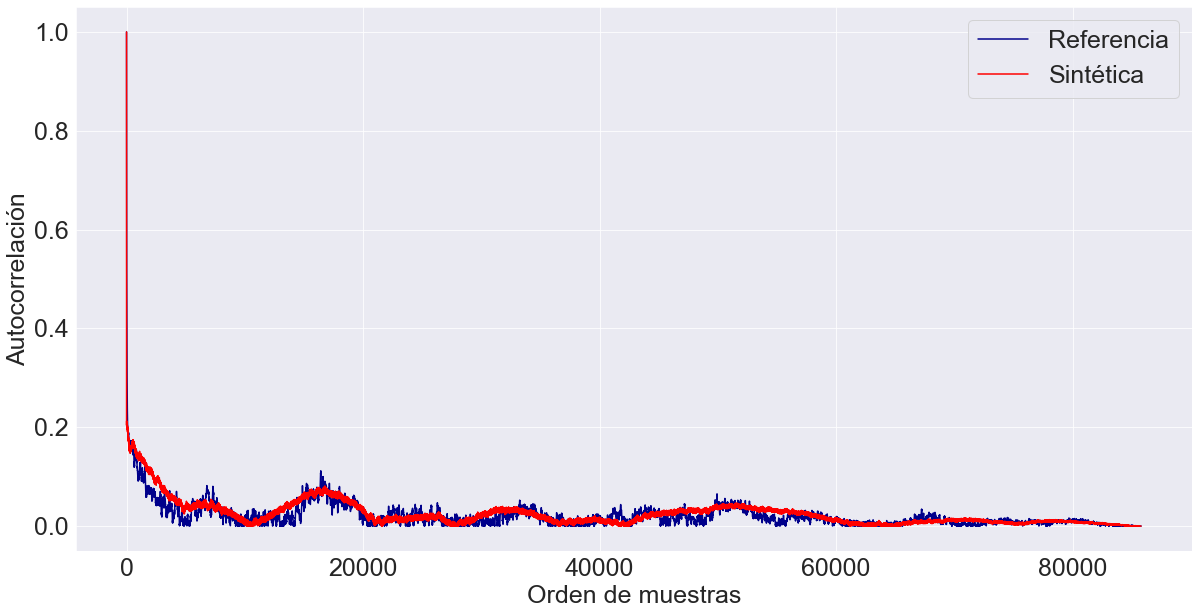

In [13]:
ws1=df_signs.ws
ws2=df_signs.Matern32_1

figname='Error_Mater32_1'
autoco(ws1, ws2, figname)

df_signs['Error_Mater32_1']=autoco.error

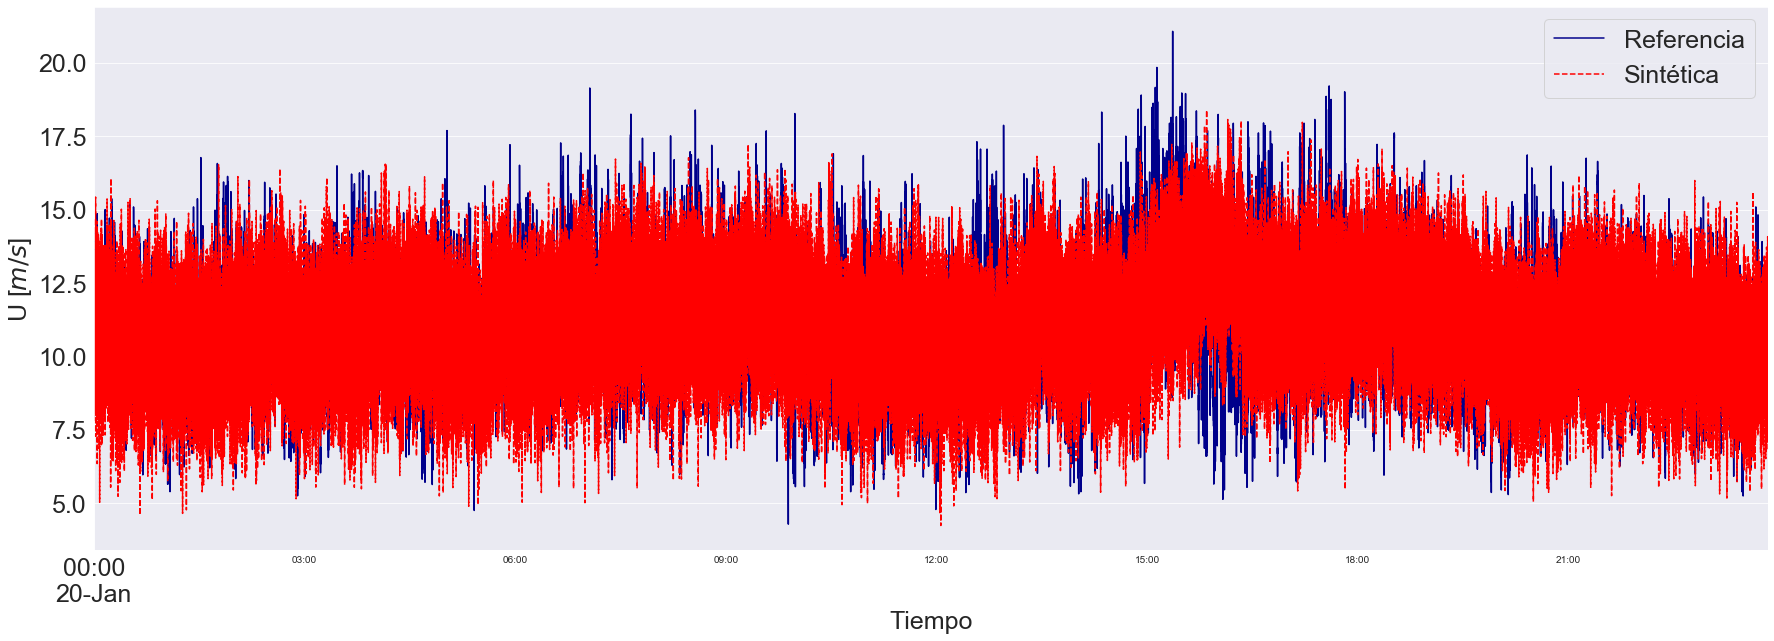

In [14]:
figname='TS_RS_24h'
two_time_serie(df_signs.ws, df_signs.Matern32_1, figname)